In [29]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==23.12.* dask-cudf-cu12==23.12.* cuml-cu12==23.12.* \
    cugraph-cu12==23.12.* cuspatial-cu12==23.12.* cuproj-cu12==23.12.* \
    cuxfilter-cu12==23.12.* cucim-cu12==23.12.* pylibraft-cu12==23.12.* \
    raft-dask-cu12==23.12.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 661.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.5/509.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip "/content/gdrive/MyDrive/digit-recognizer.zip"

Archive:  /content/gdrive/MyDrive/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [1]:
!pip install pytorch_lightning

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import sklearn
import timeit

torch.manual_seed(42)
np.random.seed(42)

In [3]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

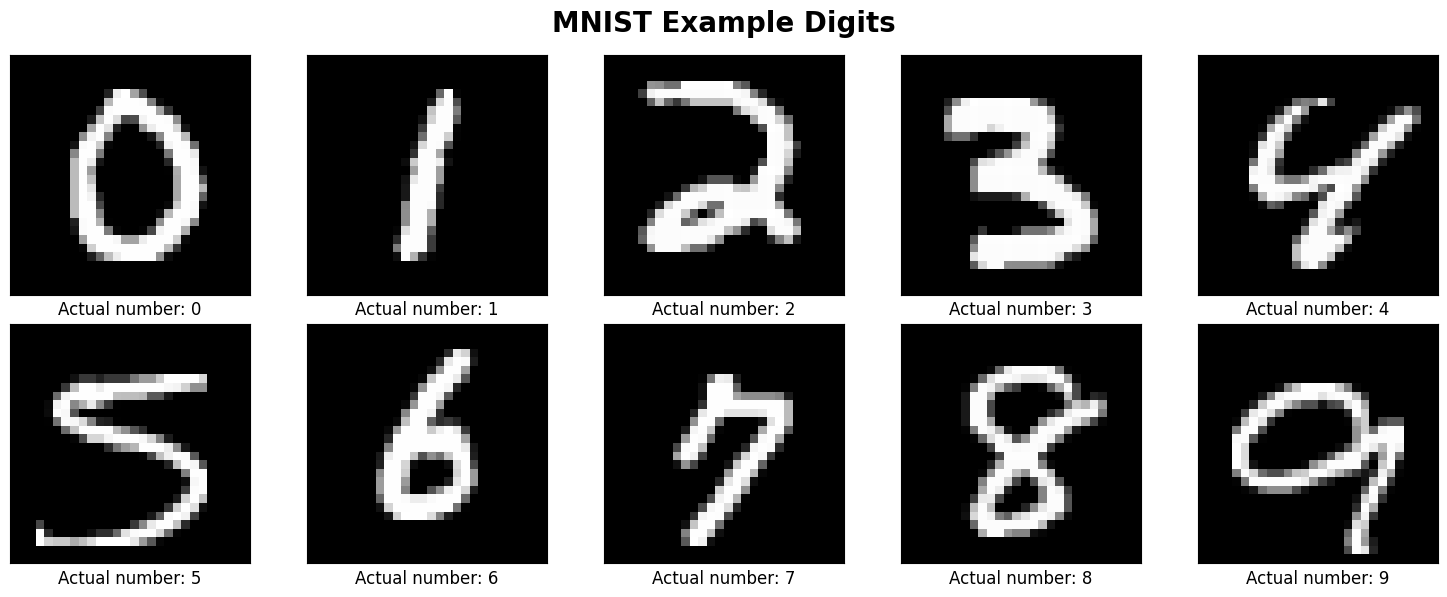

In [4]:
fig, ax = plt.subplots(2,5,figsize=(15,6))
for a in ax.ravel():
  a.set(xticks=[], yticks=[])
r=0
for c,num in zip(itertools.cycle([0,1,2,3,4]), range(10)):
  img = train.loc[train.label==num].sample()
  img = img.iloc[:,1:].to_numpy()
  img = np.resize(img,(28,28))
  ax[r,c].imshow(img, cmap='gray')
  ax[r, c].set_xlabel(f'Actual number: {num}', fontsize=12)
  if c == 4:
    r += 1
fig.suptitle('MNIST Example Digits', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
class MNISTDataset(Dataset):
  def __init__(self,csv_path, transform=None):
      self.data = pd.read_csv(csv_path)
      self.transform=transform
  def __len__(self):
      return self.data.shape[0]
  def __getitem__(self,idx):
      img = self.data.iloc[idx,1:].to_numpy()
      label = self.data.iloc[idx, 0]
      return (img, label)

In [6]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.input_size = 28 * 28

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.AvgPool2d(2),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(256, 120) # 첫 번째 완전 연결 레이어 추가
        self.fc2 = nn.Linear(120, 84)  # 수정됨
        self.fc3 = nn.Linear(84, 10)   # 수정됨
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


In [7]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'

mean = train.iloc[:,1:].mean().mean()
std = train.iloc[:, 1:].std().std()

In [8]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(mean,std)])
dataset = MNISTDataset(train_path,transform=transform)

In [9]:
train_data,val_data = torch.utils.data.random_split(dataset,[33600,8400])

In [10]:
test_data = MNISTDataset(test_path, transform=transform)

In [11]:
dataset = {}
dataset['train'], dataset['val'], dataset['test'] = train_data, val_data, test_data

In [12]:
train_loader = DataLoader(dataset['train'],shuffle=True, batch_size=32, num_workers=2)

In [13]:
test_loader = DataLoader(dataset['test'],shuffle=True, batch_size=32, num_workers=2)

In [14]:
val_loader = DataLoader(dataset['val'],shuffle=True, batch_size=32, num_workers=2)

In [15]:
len(train_loader)

1050

In [16]:
import copy
import tqdm

In [17]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, 11):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.reshape(-1,1,28, 28).float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score < _val_score:
            best_score = _val_score
            best_model_wts = copy.deepcopy(model.state_dict())

    best_model = model
    best_model.load_state_dict(best_model_wts)
    return best_model

In [18]:
from sklearn.metrics import f1_score

In [19]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.reshape(-1,1,28, 28).float().to(device)
            labels = labels.to(device)

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')

    return _val_loss, _val_score

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
model = MNISTClassifier()

In [22]:
from tqdm import tqdm


In [23]:
model = MNISTClassifier()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 263/263 [00:02<00:00, 104.16it/s]

Epoch [1], Train Loss : [18.48687] Val Loss : [2.30642] Val Weighted F1 Score : [0.01785]



100%|██████████| 263/263 [00:01<00:00, 158.13it/s]

Epoch [2], Train Loss : [2.31420] Val Loss : [2.30589] Val Weighted F1 Score : [0.01749]



100%|██████████| 263/263 [00:02<00:00, 116.63it/s]


Epoch [3], Train Loss : [2.31374] Val Loss : [2.31364] Val Weighted F1 Score : [0.02136]


100%|██████████| 263/263 [00:01<00:00, 161.14it/s]

Epoch [4], Train Loss : [2.31323] Val Loss : [2.30574] Val Weighted F1 Score : [0.01906]



100%|██████████| 263/263 [00:02<00:00, 101.90it/s]

Epoch [5], Train Loss : [2.31297] Val Loss : [2.31222] Val Weighted F1 Score : [0.01777]



100%|██████████| 263/263 [00:01<00:00, 161.08it/s]

Epoch [6], Train Loss : [2.31311] Val Loss : [2.31663] Val Weighted F1 Score : [0.01785]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-02.



100%|██████████| 263/263 [00:01<00:00, 161.29it/s]

Epoch [7], Train Loss : [2.30761] Val Loss : [2.30376] Val Weighted F1 Score : [0.02234]



100%|██████████| 263/263 [00:02<00:00, 110.29it/s]

Epoch [8], Train Loss : [2.30797] Val Loss : [2.31073] Val Weighted F1 Score : [0.01757]



100%|██████████| 263/263 [00:01<00:00, 161.75it/s]

Epoch [9], Train Loss : [2.30739] Val Loss : [2.30576] Val Weighted F1 Score : [0.01749]



100%|██████████| 263/263 [00:01<00:00, 161.00it/s]

Epoch [10], Train Loss : [2.30774] Val Loss : [2.30728] Val Weighted F1 Score : [0.02136]
Epoch 00010: reducing learning rate of group 0 to 2.5000e-02.


In [191]:
import torch
import cuml
import matplotlib.pyplot as plt


In [192]:
def embedding_fc2(data, model, device):
    model.eval()
    img = torch.Tensor(data.reshape(-1, 1, 28, 28)).float().to(device)
    out = model.conv(img)
    out = model.relu(model.fc1(out))
    out = model.relu(model.fc2(out))
    return out

In [165]:
train_ = pd.read_csv("/content/train.csv")
test_ = pd.read_csv("/content/test.csv")

In [200]:
label = train.iloc[:, 0] #all labels

In [195]:
# 데이터와 모델, 장치 설정
train = pd.read_csv("/content/train.csv")
model = MNISTClassifier()
device = 'cuda:0'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)  # 모델을 GPU로 옮깁니다.
img = train.iloc[:, 1:].to_numpy() #all images
embedding = embedding_fc2(img, model, device)

In [196]:
embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  7.4248],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  4.7322, 10.6123],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  3.8305,  5.2984],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.6015,  3.2690],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  2.4779,  1.0312],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  4.6585,  4.6292]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [197]:
embedding_cpu = embedding.detach().cpu().numpy()

In [213]:
tsne = cuml.manifold.TSNE()
tsne_result = tsne.fit_transform(embedding_cpu)

[W] [05:35:13.141626] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


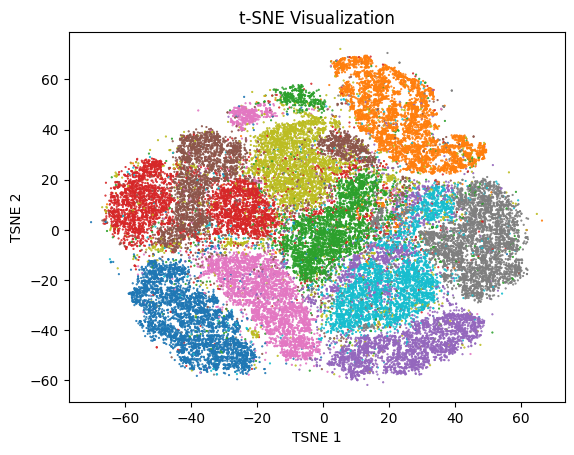

In [214]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=label, cmap='tab10', s=0.3)
plt.title('t-SNE Visualization')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

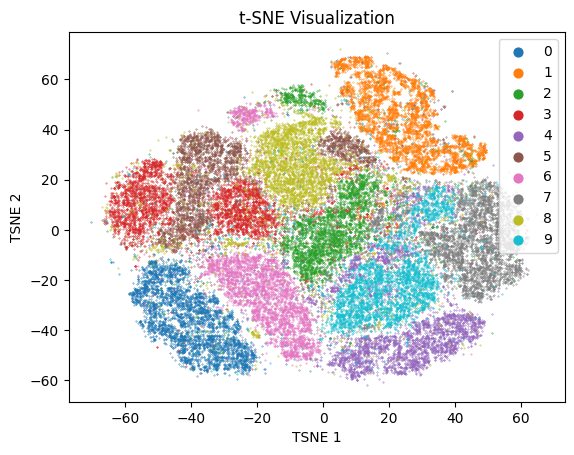

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# tsne_result와 label은 이미 계산되었다고 가정합니다.

# 색상 맵 생성
cmap = plt.cm.tab10

# 고유 라벨과 그에 대응하는 색상 추출
unique_labels = np.unique(label)
colors = [cmap(i) for i in unique_labels]

# 각 라벨 별로 scatter plot과 범례 항목 생성
for i, col in zip(unique_labels, colors):
    plt.scatter(tsne_result[label == i, 0], tsne_result[label == i, 1], c=[col], label=i, s=0.1)  # 그래프 내의 데이터 포인트 크기

# 범례 추가, 범례 내의 마커 크기 조정
plt.legend(markerscale=20)  # 범례 내의 마커 크기 조정

# 차트 제목과 축 라벨 설정
plt.title('t-SNE Visualization')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

# 그래프 표시
plt.show()
